# Compare source discretizations

There are two formulations we can use, e-b or h-j. The former discretizes e on edges, b on faces, the latter h on edges, j on faces. 

- which is better?
- how finely do we need to discretize in the theta direction?

Here, we will look at a source in a half-space. On electrode at surface, one downhole.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from SimPEG import Mesh, Utils, Maps
from discretize import utils

import casingSimulations

%matplotlib inline

In [3]:
simDir = 'Compare_3D_cyl_and_Tensor_sources_downhole'

## Use the casing mesh, no physical property contrasts

In [3]:
sigma_back = 1e-1

cyl_cp = casingSimulations.CasingParameters(
    sigma_casing = sigma_back, 
    sigma_inside = sigma_back,
    sigma_layer = sigma_back,
    sigma_back = sigma_back,
    mur_casing = 1., 
    src_a = np.r_[0., np.pi, -950.],
    src_b = np.r_[1e3, np.pi, 0.],
    freqs = [1.],
)

cart_cp = cyl_cp.copy()
cart_cp.src_a[1] = 0.
cart_cp.src_b[1] = 0.
cart_cp.src_b[0] *= -1

In [4]:
cyl_cp.save(directory=simDir, filename="cyl_cp.json")
cart_cp.save(directory=simDir, filename="tensor_cp.json")

In [45]:
npadx, npadz = 9, 9
dx2 = 1000. 
csx = 20.
csz = 20.

ncy = 3
nstretchy = 4
stretchfact = 1.6
hy = utils.meshTensor([(1, nstretchy, -stretchfact), (1, ncy), (1, nstretchy, stretchfact)])
hy = hy * 2*np.pi/hy.sum()

cylMeshGen = casingSimulations.CylMeshGenerator(
    cp=cyl_cp, 
    npadx=npadx, 
    npadz=npadz, 
    domain_x=dx2, 
    hy=hy, 
    csx=csx, 
    csz=csz
)

In [46]:
cylMeshGen.save(directory=simDir, filename="cyl_mesh.json")

In [47]:
cylMeshGen.serialize()

{u'__class__': 'CylMeshGenerator',
 'cp': {u'__class__': 'CasingParameters',
  'casing_d': 0.1,
  'casing_l': 1000.0,
  'casing_t': 0.01,
  'casing_top': 0.0,
  'freqs': [1.0],
  'layer_z': [-1000.0, -900.0],
  'mur_casing': 1.0,
  'sigma_air': 1e-08,
  'sigma_back': 0.1,
  'sigma_casing': 0.1,
  'sigma_inside': 0.1,
  'sigma_layer': 0.1,
  'src_a': [0.0, 3.141592653589793, -950.0],
  'src_b': [1000.0, 3.141592653589793, 0.0],
  'version': u'0.0.1'},
 'csx': 20.0,
 'csz': 20.0,
 'domain_x': 1000.0,
 'hy': [1.2623695010647757,
  0.7889809381654849,
  0.493113086353428,
  0.3081956789708925,
  0.1926222993568078,
  0.1926222993568078,
  0.1926222993568078,
  0.3081956789708925,
  0.493113086353428,
  0.7889809381654849,
  1.2623695010647757],
 'nca': 5,
 'ncb': 5,
 'nch': 10,
 'npadx': 9,
 'npadz': 9,
 'pfx': 1.5,
 'pfz': 1.5,
 'version': u'0.0.1'}

In [48]:
cylmesh = cylMeshGen.mesh

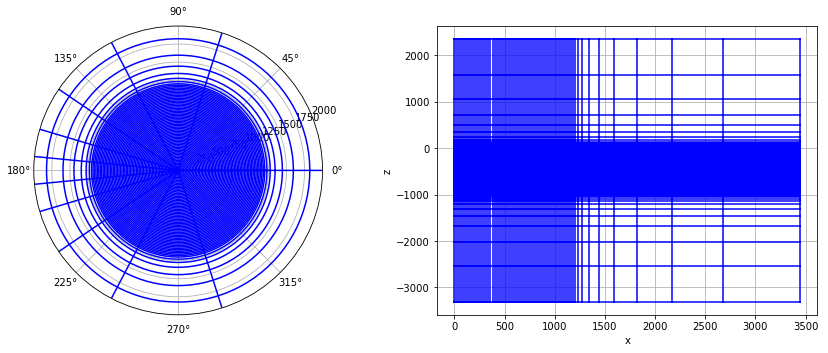

In [49]:
fig = plt.figure(figsize=(12, 5))
ax0 = plt.subplot(121, projection='polar')
ax1 = plt.subplot(122)

ax0.set_rlim([0.,2e3])

cylmesh.plotGrid(ax=[ax0, ax1])

In [50]:
cyl_cp.serialize()

{u'__class__': 'CasingParameters',
 'casing_d': 0.1,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'freqs': [1.0],
 'layer_z': [-1000.0, -900.0],
 'mur_casing': 1.0,
 'sigma_air': 1e-08,
 'sigma_back': 0.1,
 'sigma_casing': 0.1,
 'sigma_inside': 0.1,
 'sigma_layer': 0.1,
 'src_a': [0.0, 3.141592653589793, -950.0],
 'src_b': [1000.0, 3.141592653589793, 0.0],
 'version': u'0.0.1'}

In [51]:
cylMeshGen.save(simDir, 'cyl_mesh.json')

In [52]:
cylsrc = casingSimulations.sources.DownHoleTerminatingSrc(cyl_cp, cylmesh)

In [34]:
cylsrc.validate()

True

(0.0, 1500.0)

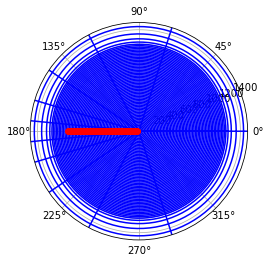

In [35]:
ax = plt.subplot(111, projection='polar')
cylmesh.plotGrid(ax=ax, slice='z')
ax.plot(cylmesh.gridFx[cylsrc.surface_wire,1], cylmesh.gridFx[cylsrc.surface_wire,0], 'ro')
ax.set_rlim([0., 1500.])

(-1.0, 2.0)

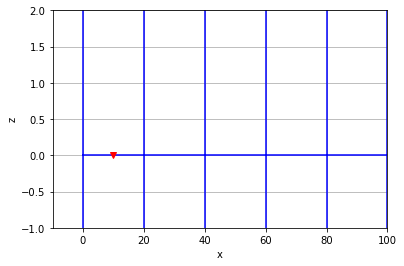

In [36]:
fig, ax = plt.subplots(1, 1)
cylmesh.plotGrid(ax=ax, slice='theta')
cylsrc.plot(ax=ax)

ax.set_xlim([-10., 100.])
ax.set_ylim([-1., 2.])

In [17]:
src_bx = -np.unique(cylmesh.gridFz[cylsrc.surface_electrode, 0])

In [37]:
cs = 10. 
cart_mesh = casingSimulations.TensorMeshGenerator(
    cp = cart_cp, 
    csx = 20., 
    csy = 20., 
    csz = 20., 
    domain_x = (cart_cp.src_a[0] - cart_cp.src_b[0]) + cylMeshGen.csx, # want a cell center at 0, 1000
    domain_y = 60.,
    pfx = cylMeshGen.pfx,
    pfy = cylMeshGen.pfx,
    pfz = cylMeshGen.pfz,
    npadx = 9,
    npady = 9,
    npadz = 9,
    nca = cylMeshGen.nca,  # number of core cells above the air-earth interface
    ncb = cylMeshGen.ncb,  # number of core cells below the borehole
    nch = 5  # number of extra cells in the horizontal direction 
)

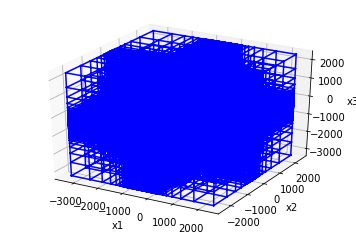

In [38]:
cart_mesh.mesh.plotGrid()

In [39]:
cart_mesh.save(directory=simDir, filename='tensor_mesh.json')

In [40]:
tensor_src = casingSimulations.sources.DownHoleTerminatingSrc(cart_cp, cart_mesh.mesh)

In [41]:
tensor_src.validate()

True

(-40, 40.0)

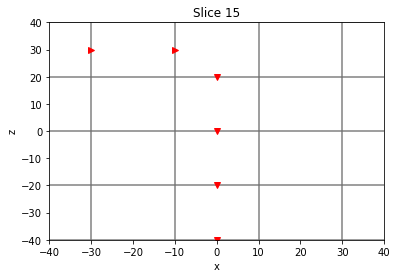

In [42]:
fig, ax = plt.subplots(1,1)
cart_mesh.mesh.plotSlice(np.nan * np.ones(cart_mesh.mesh.nC), grid=True, normal='Y', ax=ax)
tensor_src.plot(ax=ax)
ax.set_xlim([-40, 40.])
ax.set_ylim([-40, 40.])

# Load and plot the results

In [4]:
cylMesh=casingSimulations.load_properties('/'.join([simDir, 'cyl_mesh.json']))
tensorMesh=casingSimulations.load_properties('/'.join([simDir, 'tensor_mesh.json']))

cyl_cp = casingSimulations.load_properties('/'.join([simDir, 'cyl_cp.json']))
tensor_cp = casingSimulations.load_properties('/'.join([simDir, 'tensor_cp.json']))

cyl_hfield = np.load('/'.join([simDir, 'fieldsCyl.npy']))
tensor_hfield = np.load('/'.join([simDir, 'fieldsTensor.npy']))

In [5]:
cylSimulation = casingSimulations.run.SimulationFDEM(cyl_cp, cylMesh, 'DownHoleTerminatingSrc')
tensorSimulation = casingSimulations.run.SimulationFDEM(tensor_cp, tensorMesh, 'DownHoleTerminatingSrc')

In [6]:
cylSimulation.prob.model = cylSimulation.physprops.model
tensorSimulation.prob.model = tensorSimulation.physprops.model

In [7]:
cylFields = cylSimulation.prob.fieldsPair(cylMesh.mesh, cylSimulation.survey)
tensorFields = tensorSimulation.prob.fieldsPair(tensorMesh.mesh, tensorSimulation.survey)

In [8]:
cylFields[:,'hSolution'] = cyl_hfield
tensorFields[:,'hSolution'] = tensor_hfield

In [9]:
# look at currents in a slice 
jcyl = cylFields[:,'j']
jtensor = tensorFields[:,'j']

//anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:65: RuntimeWarning: invalid value encountered in less
  mask = r < 0


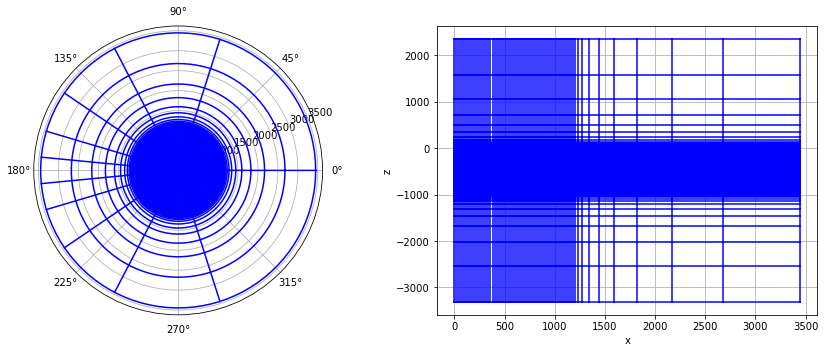

In [10]:
cylMesh.mesh.plotGrid()

In [11]:
# look at a slice along the plane of the source
jplt = casingSimulations.face3DthetaSlice(cylMesh.mesh, jcyl, theta_ind=5)

In [12]:
mesh2D = Mesh.CylMesh([cylMesh.mesh.hx, 1., cylMesh.mesh.hz], x0=cylMesh.mesh.x0)

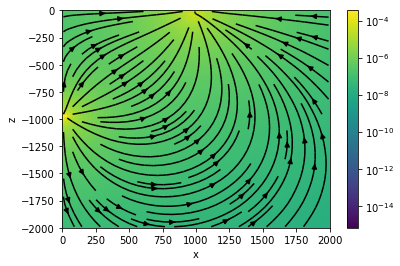

In [70]:
fig, ax = plt.subplots(1,1)
casingSimulations.plotFace2D(
    mesh2D,
    jplt, real_or_imag='real', ax=ax, range_x=np.r_[0., 2000.],
    range_y=np.r_[-2000., 0.], sample_grid=np.r_[20., 20.],
    logScale=True
)

(-2000.0, 0.0)

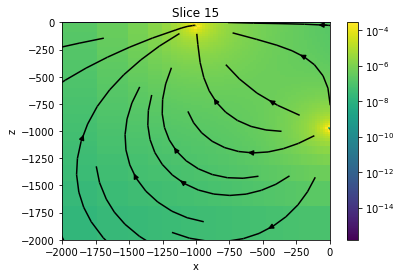

In [14]:
# here, the x-axis is reversed from the above image
fig, ax = plt.subplots(1,1)
plt.colorbar(tensorMesh.mesh.plotSlice(
    jtensor.real, vType='F', view='vec', normal='Y', range_x=np.r_[-2000., 0.],
    range_y=np.r_[-2000., 0.], ax=ax, pcolorOpts = {'norm':LogNorm()}
)[0], ax=ax)
ax.set_xlim([-2000., 0.])
ax.set_ylim([-2000., 0.])

In [15]:
# compare lines of current density

jcyl_x = jcyl[:cylMesh.mesh.vnF[0]]
jtensor_x = jtensor[:tensorMesh.mesh.vnF[0]]

In [16]:
cylgridFx = cylMesh.mesh.cartesianGrid('Fx')

## line through depth along the source line

In [17]:
# closest cartesian points
z_plt = cylMesh.mesh.vectorCCz[(cylMesh.mesh.vectorCCz < 0.) & (cylMesh.mesh.vectorCCz > -1500.)]
xyz0 = utils.ndgrid(np.r_[300.], np.r_[np.pi], z_plt)

# grab the nearest x-faces
indsx = Utils.closestPoints(cylMesh.mesh, xyz0, 'Fx')

cart_points = cylMesh.mesh.cartesianGrid('Fx')[indsx, :]

Pcart = tensorMesh.mesh.getInterpolationMat(cart_points, 'Fx')

jx_cart = Pcart * jtensor

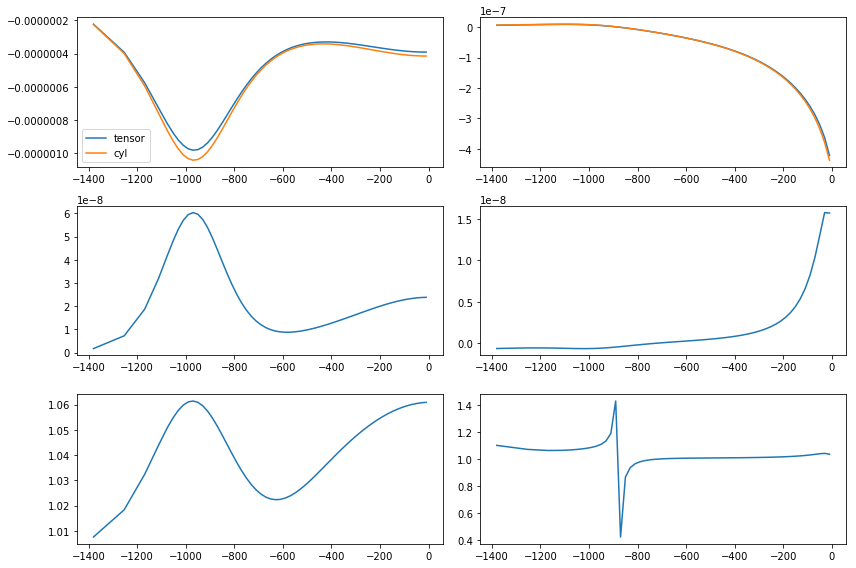

In [18]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
ax = utils.mkvc(ax)
ax[0].plot(z_plt, jx_cart.real)
ax[0].plot(z_plt, -jcyl_x[indsx].real)

ax[0].legend(['tensor', 'cyl'])

ax[1].plot(z_plt, jx_cart.real + jcyl_x[indsx].real)

ax[2].plot(z_plt, -jcyl_x[indsx].real / jx_cart.real)

ax[3].plot(z_plt, jx_cart.imag)
ax[3].plot(z_plt, -jcyl_x[indsx].imag)

ax[4].plot(z_plt, jx_cart.imag + jcyl_x[indsx].imag)

ax[5].plot(z_plt, -jcyl_x[indsx].imag / jx_cart.imag)

plt.tight_layout()

## look at y-component along a line through depth ($\theta$ = $\pi/2$)

In [19]:
# closest cartesian points
z_plt = cylMesh.mesh.vectorCCz[(cylMesh.mesh.vectorCCz < 0.) & (cylMesh.mesh.vectorCCz > -1500.)]
xyz0 = utils.ndgrid(np.r_[200.], np.r_[np.pi/2.], z_plt)

# grab the nearest x-faces
inds_pi2 = Utils.closestPoints(cylMesh.mesh, xyz0, 'Fx')

cart_points = cylMesh.mesh.cartesianGrid('Fx')[inds_pi2, :]

Pcart = tensorMesh.mesh.getInterpolationMat(cart_points, 'Fy')

jy_cart = Pcart * jtensor
jy_cyl = utils.sdiag(np.sin(cylMesh.mesh.gridFx[inds_pi2, 1])) * jcyl[inds_pi2]

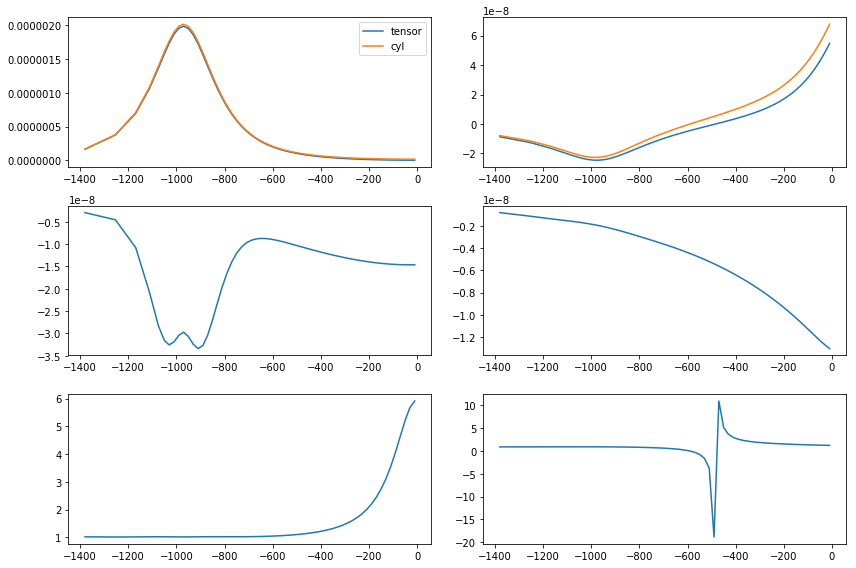

In [20]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
ax = utils.mkvc(ax)
ax[0].plot(z_plt, jy_cart.real)
ax[0].plot(z_plt, jy_cyl.real)

ax[0].legend(['tensor', 'cyl'])

ax[1].plot(z_plt, jy_cart.real - jy_cyl.real)
ax[2].plot(z_plt, jy_cyl.real/jy_cart.real)

ax[3].plot(z_plt, jy_cart.imag)
ax[3].plot(z_plt, jy_cyl.imag)

ax[4].plot(z_plt, jy_cart.imag - jy_cyl.imag)
ax[5].plot(z_plt, jy_cyl.imag/jy_cart.imag)

plt.tight_layout()

## look at x, y components along a theta face. 

This is more subtle. Need to convert to cartesian, then average. 

In [66]:
# closest cartesian points
z_plt = cylMesh.mesh.vectorCCz[(cylMesh.mesh.vectorCCz < 0.) & (cylMesh.mesh.vectorCCz > -1500.)]
xyz0 = utils.ndgrid(np.r_[300.], np.r_[3*np.pi/2.], z_plt)

# grab the nearest y-faces
inds_theta = Utils.closestPoints(cylMesh.mesh, xyz0, 'Fy')

cart_points = cylMesh.mesh.cartesianGrid('Fy')[inds_theta, :]

Pcartx = tensorMesh.mesh.getInterpolationMat(cart_points, 'Fx')
Pcarty = tensorMesh.mesh.getInterpolationMat(cart_points, 'Fy')

jx_cart = Pcartx * jtensor
jy_cart = Pcarty * jtensor

jx_cyl = - utils.sdiag(np.sin(cylMesh.mesh.gridFy[inds_theta, 1])) * jcyl[inds_theta + cylMesh.mesh.vnF[0]]
jy_cyl = utils.sdiag(np.cos(cylMesh.mesh.gridFy[inds_theta, 1])) * jcyl[inds_theta + cylMesh.mesh.vnF[0]]

In [67]:
np.sin(cylMesh.mesh.gridFy[inds_theta, 1])

array([-0.9528123, -0.9528123, -0.9528123, -0.9528123, -0.9528123,
       -0.9528123, -0.9528123, -0.9528123, -0.9528123, -0.9528123,
       -0.9528123, -0.9528123, -0.9528123, -0.9528123, -0.9528123,
       -0.9528123, -0.9528123, -0.9528123, -0.9528123, -0.9528123,
       -0.9528123, -0.9528123, -0.9528123, -0.9528123, -0.9528123,
       -0.9528123, -0.9528123, -0.9528123, -0.9528123, -0.9528123,
       -0.9528123, -0.9528123, -0.9528123, -0.9528123, -0.9528123,
       -0.9528123, -0.9528123, -0.9528123, -0.9528123, -0.9528123,
       -0.9528123, -0.9528123, -0.9528123, -0.9528123, -0.9528123,
       -0.9528123, -0.9528123, -0.9528123, -0.9528123, -0.9528123,
       -0.9528123, -0.9528123, -0.9528123, -0.9528123, -0.9528123,
       -0.9528123, -0.9528123, -0.9528123])

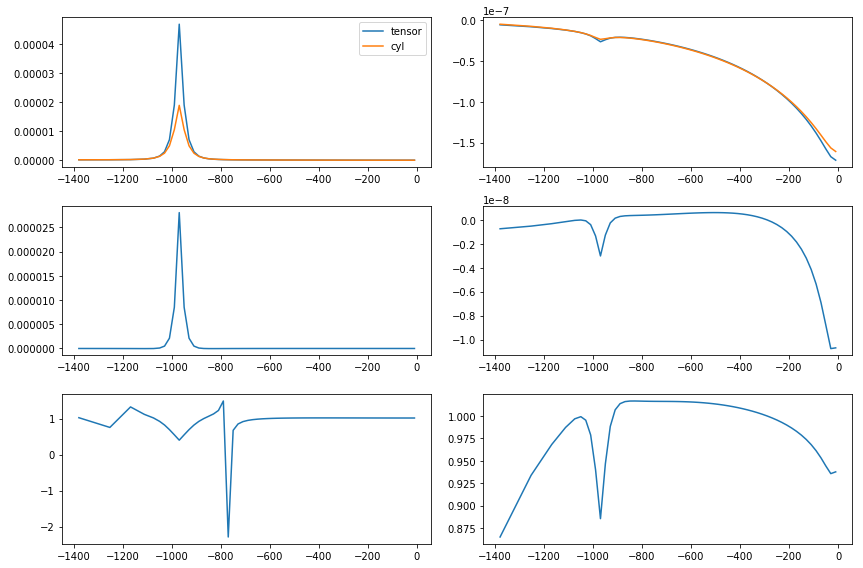

In [134]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
ax = utils.mkvc(ax)
ax[0].plot(z_plt, jx_cart.real)
ax[0].plot(z_plt, jx_cyl.real)

ax[0].legend(['tensor', 'cyl'])

ax[1].plot(z_plt, jx_cart.real - jx_cyl.real)
ax[2].plot(z_plt, jx_cyl.real/jx_cart.real)

ax[3].plot(z_plt, jx_cart.imag)
ax[3].plot(z_plt, jx_cyl.imag)

ax[4].plot(z_plt, jx_cart.imag - jx_cyl.imag)
ax[5].plot(z_plt, jx_cyl.imag/jx_cart.imag)

plt.tight_layout()

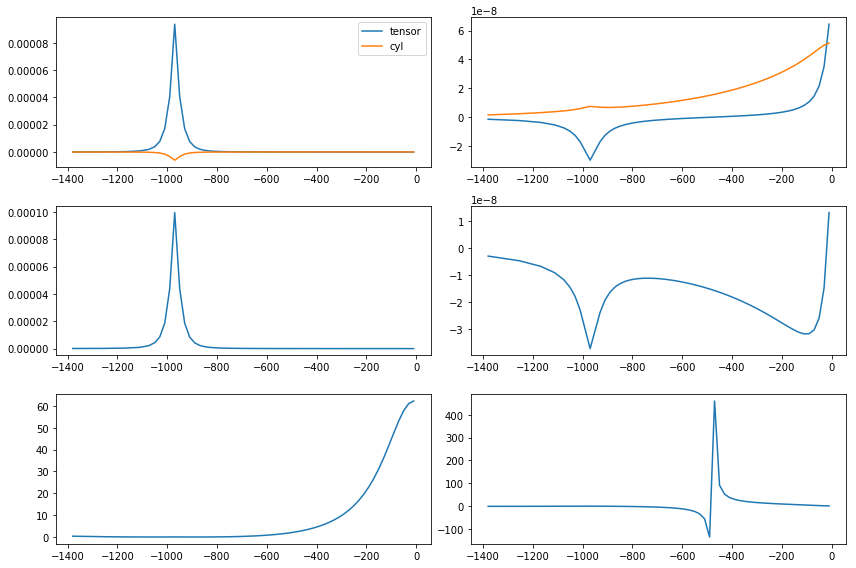

In [135]:
fig, ax = plt.subplots(3,2, figsize=(12,8))
ax = utils.mkvc(ax)
ax[0].plot(z_plt, jy_cart.real)
ax[0].plot(z_plt, jy_cyl.real)

ax[0].legend(['tensor', 'cyl'])

ax[1].plot(z_plt, jy_cart.real - jy_cyl.real)
ax[2].plot(z_plt, jy_cyl.real/jy_cart.real)

ax[3].plot(z_plt, jy_cart.imag)
ax[3].plot(z_plt, jy_cyl.imag)

ax[4].plot(z_plt, jy_cart.imag - jy_cyl.imag)
ax[5].plot(z_plt, jy_cyl.imag/jy_cart.imag)

plt.tight_layout()

This comparison is a bit subtle - for this orientation, fields are quite small. It is also unclear if the tensor is a good enough approximation. See <a href="./Compare_3D_HED.ipynb">Comparison with HED</a> for an analytical solution. 